# 🧠 End-to-End: Forecasting Daily Energy Prices with Random Forest

In [2]:
# 📦 Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


## 1. Load and Preprocess Raw Data

In [ ]:
# 🔹 Simulated raw data
# data = {
#     "Datetime": ["2018-01-01 14:00:00", "2018-01-02 14:00:00", "2018-01-03 14:00:00", 
#                  "2018-01-04 14:00:00", "2018-01-05 14:00:00", "2018-01-06 14:00:00",
#                  "2018-01-07 14:00:00", "2018-01-08 14:00:00", "2018-01-09 14:00:00",
#                  "2018-01-10 14:00:00", "2018-01-11 14:00:00", "2018-01-12 14:00:00"],
#     "MarginalES": [2.3, 48.02, 52.0, 48.19, 50.3, 51.7, 53.0, 49.8, 47.5, 45.6, 46.1, 44.3]
# }
# df = pd.DataFrame(data)
# df['Datetime'] = pd.to_datetime(df['Datetime'])
# df.set_index('Datetime', inplace=True)
df = pd.read_csv('../../data/hour_14_metrics.csv', parse_dates=["Datetime"])


## 2. Feature Engineering

In [ ]:
# Add lag features
df['lag_1'] = df['MarginalES'].shift(1)
df['lag_7'] = df['MarginalES'].shift(7)

# Rolling features
df['rolling_mean_7'] = df['MarginalES'].rolling(window=7).mean()
df['rolling_std_7'] = df['MarginalES'].rolling(window=7).std()



# Ensure DatetimeIndex
df.index = pd.to_datetime(df.index)

# Date features
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear

# Drop NA rows caused by shifting and rolling
df.dropna(inplace=True)


## 3. Train/Validation/Test Split

In [11]:
features = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'dayofweek', 'month', 'dayofyear']
target = 'MarginalES'

X = df[features]
y = df[target]

# # 70/15/15 split (chronologically)
# split_1 = int(len(df) * 0.7)
# split_2 = int(len(df) * 0.85)
# X_train, y_train = X.iloc[:split_1], y.iloc[:split_1]
# X_val, y_val = X.iloc[split_1:split_2], y.iloc[split_1:split_2]
# X_test, y_test = X.iloc[split_2:], y.iloc[split_2:]

# 80 / 20 split (chronologically for just train and test)
split_1 = int(len(df) * 0.7)
X_train, y_train = X.iloc[:split_1], y.iloc[:split_1]   
X_test, y_test = X.iloc[split_1:], y.iloc[split_1:]

## 4. Train Random Forest Model

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## 5. Evaluation

In [13]:
def evaluate(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    print(f"{label} MAE: {mae:.2f}")
    print(f"{label} RMSE: {rmse:.2f}")
    return mae, rmse

# # Validation
# y_val_pred = model.predict(X_val)
# evaluate(y_val, y_val_pred, label="Validation")

# Test
y_test_pred = model.predict(X_test)
evaluate(y_test, y_test_pred, label="Test")


Test MAE: 21.66
Test RMSE: 28.84


(21.663467300380226, 28.835990370264813)

## 6. Plot Predictions vs Actual

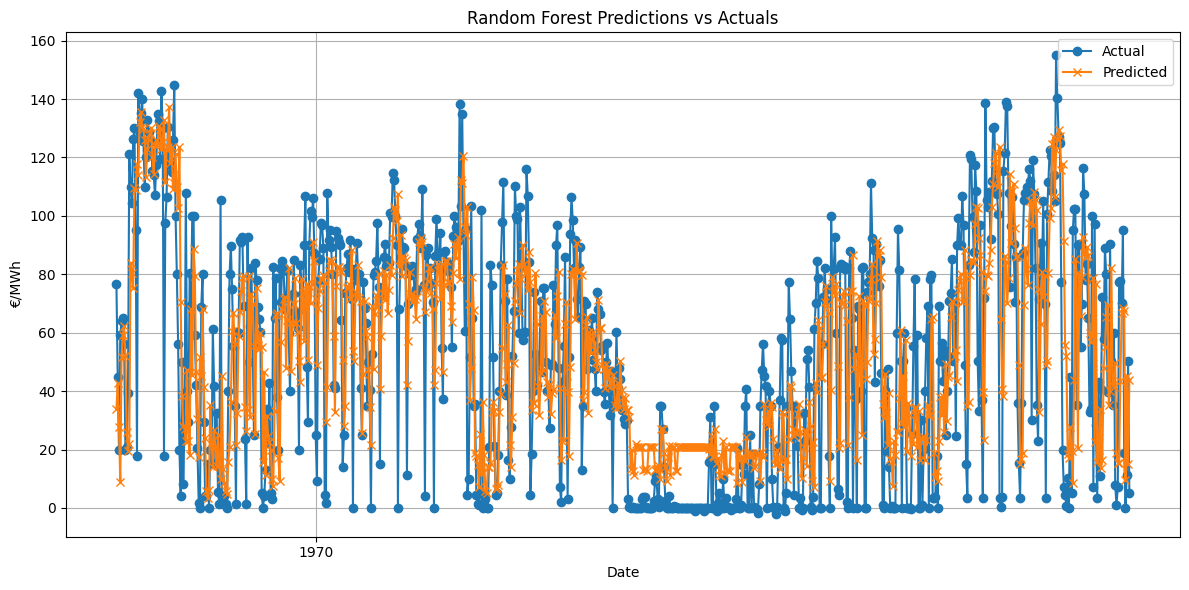

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted', marker='x')
plt.title("Random Forest Predictions vs Actuals")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
